# BERT Text Classification
https://github.com/susanli2016/NLP-with-Python/blob/master/Text_Classification_With_BERT.ipynb

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Dataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_json('/content/dataset/Q2_Dataset.cleaned-general.json')

In [5]:
print(df.columns)
df.head(3)

Index(['tweet_text', 'label', 'topic'], dtype='object')


,tweet_text,label,topic
0,Ebola is not going to come close to you your ...,6,other_useful_information
1,It is too funny to watch MSNBC put an infectio...,3,treatment
2,How the GOP fights infectious disease Ebola,6,other_useful_information


In [6]:
df['topic'].value_counts()

not_related_or_irrelevant    3592
other_useful_information     1880
affected_people              1031
deaths_reports                643
treatment                     640
prevention                    579
disease_transmission          525
disease_signs_or_symptoms     429
Name: topic, dtype: int64

In [7]:
label_dict={}
for n in df['label'].unique():
    topic=df[df['label']==n]['topic'].unique()
    if not len(topic)==1:
        raise Exception(f'ERROR : Label to Topic ({n}=>{topic}) Mapping not 1:1')
    print(f'INFO : {n}=>{topic}')
    label_dict[topic[0]]=n

label_dict

INFO : 6=>['other_useful_information']
INFO : 3=>['treatment']
INFO : 1=>['disease_transmission']
INFO : 0=>['disease_signs_or_symptoms']
INFO : 7=>['not_related_or_irrelevant']
INFO : 2=>['prevention']
INFO : 4=>['deaths_reports']
INFO : 5=>['affected_people']


{'affected_people': 5,
 'deaths_reports': 4,
 'disease_signs_or_symptoms': 0,
 'disease_transmission': 1,
 'not_related_or_irrelevant': 7,
 'other_useful_information': 6,
 'prevention': 2,
 'treatment': 3}

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

## BERT Tokenizer

In [8]:
! pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.7 MB/s 
     |████████████████████████████████| 6.6 MB 68.0 MB/s 
     |████████████████████████████████| 101 kB 14.5 MB/s 
     |████████████████████████████████| 596 kB 75.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [9]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [11]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [12]:
print(df.groupby(['label', 'data_type'])['tweet_text'].count())

label  data_type
0      train         365
       val            64
1      train         446
       val            79
2      train         492
       val            87
3      train         544
       val            96
4      train         547
       val            96
5      train         876
       val           155
6      train        1598
       val           282
7      train        3053
       val           539
Name: tweet_text, dtype: int64


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [14]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].tweet_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].tweet_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [16]:
len(dataset_train), len(dataset_val)

(7921, 1398)

## BERT Model Sequence Classification

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [21]:
from sklearn.metrics import f1_score, accuracy_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [22]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Load GPU

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [24]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

## Train

In [28]:
epochs=4

epoch_history=[]

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'model/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_score = accuracy_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    # tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {val_score}')

    epoch_data = {
        'Epoch' : epoch,
        'Training Loss' : loss_train_avg,
        'Validation Loss' : val_loss,
        'Accuracy Score' : val_score,
    }

    epoch_history.append(epoch_data)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/793 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.662296624955208
Validation loss: 0.7936857803059476
Accuracy Score: 0.7510729613733905


Epoch 2:   0%|          | 0/793 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5399289318556518
Validation loss: 0.8717900875157544
Accuracy Score: 0.7267525035765379


Epoch 3:   0%|          | 0/793 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4448744498597268
Validation loss: 0.8566634360434754
Accuracy Score: 0.751788268955651


Epoch 4:   0%|          | 0/793 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.39448404218179434
Validation loss: 0.864391546882689
Accuracy Score: 0.748211731044349


# Save Model

In [29]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
model.load_state_dict(torch.load('./model/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from google.colab import files
files.download('./model/finetuned_BERT_epoch_1.model') 

In [31]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [32]:
# accuracy_per_class(predictions, true_vals)
label_dict_inverse = {v: k for k, v in label_dict.items()}
preds_flat = np.argmax(predictions, axis=1).flatten()

In [33]:
preds_flat

array([6, 6, 0, ..., 6, 7, 7])

## Model Performance

In [34]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [36]:
balanced_accuracy_score(true_vals, preds_flat, adjusted=True)

0.6659899684179958

## Epoch Analysis

- Evidently model was overfitting from the get-go.

- Training Loss continued to drop with Epoch but Validation Loss increased.

- Due to the divergence, applied early stop

- Suggests that we need a larger dataset and/or use lower learning rate.


In [39]:
# from glob import glob
# import pandas as pd
# import os
from helper.metrics import analyse_epoch

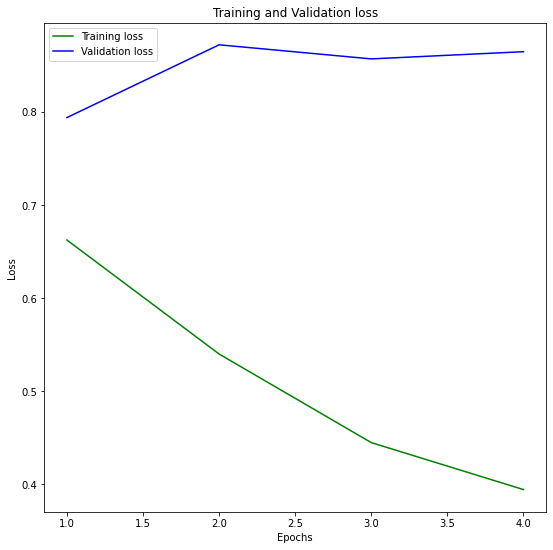

In [40]:
epoch_data={ 'epoch':[], 'loss':[], 'val_loss':[] }
for n in range(len(epoch_history)):
    epoch_data['epoch'].append(n+1)
    epoch_data['val_loss'].append(epoch_history[n]['val_loss'])
    epoch_data['loss'].append(epoch_history[n]['loss'])
    
epoch_data
analyse_epoch(epoch_data, filepath='./plot/epoch_BERT.png')

In [39]:
from helper.metrics import plot_confusion_matrix

Accuracy :75.1%


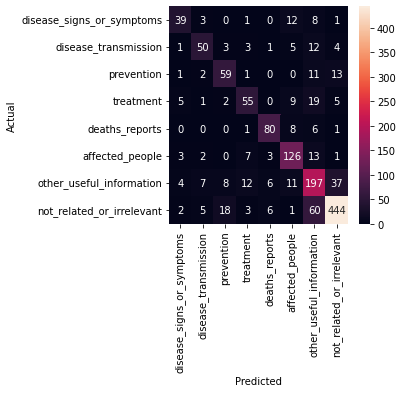

In [51]:
plot_confusion_matrix(true_vals, preds_flat, classes=label_dict)